# **Wildfire Smoke

## **0.** Settings

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install albumentations==0.4.6
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65152 sha256=3b56c92c71ae3541aed9718d64384e70b746254d1ce6c448fb78007a86f39090
  Stored in directory: /root/.cache/pip/wheels/f9/d7/0c/6ed42fd872f7d1af78b25045f8b16be330f2c70ae72c83e37d
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1


In [ ]:
import sys
#sys.path.insert(0,'/content/drive/MyDrive/Wildfire-Smoke-Detection')

In [ ]:
#sys.path.insert(0,'/content/drive/MyDrive/Wildfire-Smoke-Detection/Detection/engine.py')

In [ ]:
#print(sys.path)

In [ ]:
#l = sys.path
#l_mod = l[:-2]
#print(l_mod)

In [1]:
#sys.path = l_mod

In [ ]:
engine_path = "/content/drive/MyDrive/Wildfire-Smoke-Detection/Detection"

In [ ]:
# main_script.py
import sys
sys.path.append(engine_path)

from engine import evaluate


In [ ]:
from torchvision.models.detection.rpn import AnchorGenerator
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.models.detection import FasterRCNN
from engine import train_one_epoch, evaluate
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import albumentations as A
import pandas as pd
import torchvision
import numpy as np
import torch
import cv2
import os

In [ ]:
## ===========================
##   GPU
## ===========================

gpu = True

if gpu == True:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## **1.** Dataset

In [ ]:
# Unzip the dataset
!unzip '/content/drive/MyDrive/Wildfire-Smoke-Detection/dataset-CSV.zip'

Archive:  /content/drive/MyDrive/Wildfire-Smoke-Detection/dataset-CSV.zip
  inflating: test/ck0kcoc8ik6ni0848clxs0vif_jpeg.rf.8b4629777ffe1d349cc970ee8af59eac.jpg  
  inflating: test/ck0kd4afx8g470701watkwxut_jpeg.rf.bb5a1f2c2b04be20c948fd3c5cec33ff.jpg  
  inflating: test/ck0kdhymna0b10721v4wntit8_jpeg.rf.a08e34d04fb672ce6cf8e94e810ec81d.jpg  
  inflating: test/ck0kepbs9kdym0848hgpcf3y9_jpeg.rf.d0a63becb54a83b6b026f4b38a42933b.jpg  
  inflating: test/ck0kewsaha6hh07215jgx1bp2_jpeg.rf.1a375d20560d0de016bb524921f7b2a9.jpg  
  inflating: test/ck0kfhu4n8q7f0701ixmonyig_jpeg.rf.a3cc5282520b3bac90718bdd5528bd76.jpg  
  inflating: test/ck0kfjen48qhj0701wjkosmel_jpeg.rf.49b365cc7135deee1332e6657401abc5.jpg  
  inflating: test/ck0khrg9xan7u0721mn5rxpzo_jpeg.rf.1f545d6c898ea9bad6147d7833f9b83f.jpg  
  inflating: test/ck0khu2xz94nj070165dkfirk_jpeg.rf.d511cbdb4c1162cf08d710561abef2b3.jpg  
  inflating: test/ck0kmf5q58yik0944gdwwrqnt_jpeg.rf.acd14651f0f7c3762be88a81ee82e1a2.jpg  
  inflating: tes

In [ ]:
!ls /content

drive  sample_data


## **2.** Train and validation sets

In [ ]:
# Path for annotations (train and validation)
train_csv_path = '/content/train_annotations.csv'
valid_csv_path = '/content/valid_annotations.csv'

# Path for images (train and validation)
train_images = '/content/train'
valid_images = '/content/valid'

In [ ]:
# Train
train_csv = pd.read_csv(train_csv_path)
train_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,ck0qd8gs6ko7j0721x25cv4o3_jpeg.rf.005f5707706e...,640,480,smoke,125,190,177,286
1,ck0t40rhdz68s0a46ekx049a6_jpeg.rf.00403179fe5f...,640,480,smoke,326,207,494,249
2,ck0m0ch9ugnna07940o8x989j_jpeg.rf.0101cdb46a16...,640,480,smoke,308,166,582,257
3,ck0rr6bfa9b3w0721aw5unwdy_jpeg.rf.00982c053d66...,640,480,smoke,241,204,310,244
4,ck0uk75x5ysls0721e5a9j891_jpeg.rf.00d7fd8503e1...,640,480,smoke,523,208,619,288


In [ ]:
# Validation
valid_csv = pd.read_csv(valid_csv_path)
valid_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,ck0k9aqm99o2o0721aml8qpqr_jpeg.rf.028c79a871f1...,640,480,smoke,396,211,493,243
1,ck0ndrnhi3fkn0794vbn53c08_jpeg.rf.00da459deaa7...,640,480,smoke,195,205,213,225
2,ck0ncvnd332hj079400vhocib_jpeg.rf.01edcd18890b...,640,480,smoke,1,170,160,325
3,ck0ovrdff7ir20848kelskyn8_jpeg.rf.1424f9ef8aad...,640,480,smoke,312,114,560,259
4,ck0tx0999u6br0944s68atde0_jpeg.rf.0e5c93b75738...,640,480,smoke,238,256,526,315


## **3.** Labels encoding

In [ ]:
# Define categories
categories = train_csv['class'].unique()
print(categories)

['smoke']


In [ ]:
## Encode the categories with integers
## (the train set define the encodings, the other sets have to adapt to that encodings)

# ====================
#   Train set
# ====================
class LabelMap:

    def __init__(self, categories):

        self.map_dict = {}
        self.reverse_map_dict = {}

        # Assign to every category an integer (starting from 1)
        for i, cat in enumerate(categories):
            self.map_dict[cat] = i + 1
            self.reverse_map_dict[i] = cat

    def fit(self, df, column):
        df[column] = df[column].map(self.map_dict)
        return df

# ====================
#   Other sets
# ====================
def encode_label(df, column, map_dict):
    df[column] = df[column].map(map_dict)
    return df

In [ ]:
# Create an instance of the class
label_map = LabelMap(categories)

In [ ]:
# Encode the labels of the train set
train_csv = label_map.fit(train_csv, 'class')
train_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,ck0qd8gs6ko7j0721x25cv4o3_jpeg.rf.005f5707706e...,640,480,1,125,190,177,286
1,ck0t40rhdz68s0a46ekx049a6_jpeg.rf.00403179fe5f...,640,480,1,326,207,494,249
2,ck0m0ch9ugnna07940o8x989j_jpeg.rf.0101cdb46a16...,640,480,1,308,166,582,257
3,ck0rr6bfa9b3w0721aw5unwdy_jpeg.rf.00982c053d66...,640,480,1,241,204,310,244
4,ck0uk75x5ysls0721e5a9j891_jpeg.rf.00d7fd8503e1...,640,480,1,523,208,619,288


In [ ]:
# Encode the labels of the validation set
valid_csv = encode_label(valid_csv, 'class', label_map.map_dict)
valid_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,ck0k9aqm99o2o0721aml8qpqr_jpeg.rf.028c79a871f1...,640,480,1,396,211,493,243
1,ck0ndrnhi3fkn0794vbn53c08_jpeg.rf.00da459deaa7...,640,480,1,195,205,213,225
2,ck0ncvnd332hj079400vhocib_jpeg.rf.01edcd18890b...,640,480,1,1,170,160,325
3,ck0ovrdff7ir20848kelskyn8_jpeg.rf.1424f9ef8aad...,640,480,1,312,114,560,259
4,ck0tx0999u6br0944s68atde0_jpeg.rf.0e5c93b75738...,640,480,1,238,256,526,315


## **4.** Prepare the data

In [ ]:
class WildFireSmoke_Dataset(torch.utils.data.Dataset):

    def __init__(self, df, image_path, categories, transforms=None, **kwargs):
        super().__init__(**kwargs)
        self.df         = df
        self.image_path = image_path
        self.categories = categories
        self.images     = self.df['filename'].unique()
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    #------------------------------------------------------------------------ Extract 'idx'-th item ---------#
    def __getitem__(self, idx):                                                                              #
                                                                                                             #
        # Define the 'idx'-th image path                                                                     #
        image_file = os.path.join(self.image_path, self.images[idx])                                         #
                                                                                                             #
        # Get the image                                                                                      #
        img = cv2.imread(image_file)                                                                         #
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                                                           #
        img = img.astype(np.float32)                                                                         #
        img = img/255.0                                                                                      #
                                                                                                             #
        # Get the box/s coordinates for each element                                                         #
        image_data = self.df[self.df['filename'] == self.images[idx]]                                        #
        xmins = image_data['xmin'].values                                                                    #
        ymins = image_data['ymin'].values                                                                    #
        xmaxs = image_data['xmax'].values                                                                    #
        ymaxs = image_data['ymax'].values                                                                    #
                                                                                                             #
        # Convert everything into a torch.Tensor                                                             #
        boxes = torch.as_tensor(np.stack([xmins, ymins, xmaxs, ymaxs], axis=1), dtype=torch.float32)         #
        labels = torch.as_tensor(image_data['class'].values, dtype=torch.int64)                              #
        image_id = torch.tensor([idx])                                                                       #
                                                                                                             #
        # Calculate the area/s of the box/s                                                                  #
        areas = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])                                        #
        areas = torch.as_tensor(areas, dtype=torch.float32)                                                  #
                                                                                                             #
        # Format                                                                                             #
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)                                             #
                                                                                                             #
        # Target (dict) definition                                                                           #
        target = {}                                                                                          #
        target['boxes']    = boxes                                                                           #
        target['labels']   = labels                                                                          #
        target['image_id'] = image_id                                                                        #
        target['area']     = areas                                                                           #
        target['iscrowd']  = iscrowd                                                                         #
                                                                                                             #
        # Data transformations                                                                               #
        if self.transforms is not None:                                                                      #
                                                                                                             #
            # Define transformation                                                                          #
            transformed = self.transforms(image=img, bboxes=boxes, labels=labels)                            #
                                                                                                             #
            # Image transformation                                                                           #
            img = transformed['image']                                                                       #
                                                                                                             #
            # Target transformation                                                                          #
            target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)                    #
                                                                                                             #
        return torch.as_tensor(img, dtype=torch.float32), target                                             #
    #--------------------------------------------------------------------------------------------------------#

    def get_height_and_width(self, image):
        image_data = self.df.loc[self.df['filename'] == image]
        return image_data['width'].values[0], image_data['height'].values[0]

In [ ]:
# Train set transformations
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2(p=1)], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Validation set transformations
transform_valid = A.Compose([
    ToTensorV2(p=1)], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [ ]:
# Define a custom collate: collate_fn
# (it collates the input samples into a batch to then pass the whole batch to the data loader iterator)

def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# Finally import train and validation
train_dataset = WildFireSmoke_Dataset(train_csv, train_images, categories, transform_train)
valid_dataset = WildFireSmoke_Dataset(valid_csv, valid_images, categories, transform_valid)

data_loader_train = torch.utils.data.DataLoader(
        train_dataset,
        batch_size  = 4,
        shuffle     = True,
        num_workers = 2,
        collate_fn  = collate_fn)

data_loader_valid = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size  = 4,
        shuffle     = False,
        num_workers = 2,
        collate_fn  = collate_fn)

## **5.** Plot images and boxes

In [ ]:
def plot_images(images, targets):

    max_images = 4
    count_imgs = 0

    for image, target in zip(images, targets):

        if count_imgs == max_images:
            break;

        count_imgs += 1

        # Get the image and the boxes in the right format
        sample = image.permute(1,2,0).cpu().numpy()
        boxes  = target['boxes'].cpu().numpy().astype(np.int32)

        # Define the plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

        # Plot the boxes
        for box in boxes:
            cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (1,0,0), 2);

            cv2.putText(sample, 'SMOKE',
                      (box[0], box[1]-10), cv2.FONT_HERSHEY_DUPLEX, 0.8, (1,0,0), 2)

        # Additional
        ax.set_axis_off();
        ax.imshow((sample * 255).astype(np.uint8))

In [ ]:
# Train set - images and boxes
images, targets = next(iter(data_loader_train))
plot_images(images, targets)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Validation set - images and boxes
images, targets = next(iter(data_loader_valid))
plot_images(images, targets)

Output hidden; open in https://colab.research.google.com to view.

## **6.** Model definition

### **6.1.** Import the pre-trained model

Available models, pre-trained on COCO dataset, at https://pytorch.org/vision/master/models/faster_rcnn.html.

In [ ]:
# Transfer learning: load a model pre-trained on COCO
detection_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 144MB/s]


### **6.2.** Adjust the classifier

In [ ]:
## Replace the classifier with a new one, that has num_classes which is user-defined

# Define the number of classes (len(categories) + 'background')
num_classes = len(categories) + 1

# Get the number of input features for the classifier
in_features = detection_model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
detection_model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

### **6.3.** Move the model to `device`

In [ ]:
# Move the model to 'device'
detection_model = detection_model.to(device)

## **7.** Training

In [ ]:
from engine import train_one_epoch, evaluate
import torch

In [ ]:
def training(model, train_loader, val_loader, epochs):

    # Optimizer and learning rate
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    # Adapter
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(epochs):

        # Train for one epoch, printing every 'print_freq'
        train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=len(data_loader_train))

        # Update the learning rate
        lr_scheduler.step()

        # Evaluate on the validation set
        evaluate(model, val_loader, device=device)

training(detection_model, data_loader_train, data_loader_valid, epochs=5)

Epoch: [0]  [  0/129]  eta: 0:05:25  lr: 0.000044  loss: 0.8355 (0.8355)  loss_classifier: 0.6475 (0.6475)  loss_box_reg: 0.1872 (0.1872)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 2.5251  data: 0.4460  max mem: 6137
Epoch: [0]  [128/129]  eta: 0:00:01  lr: 0.005000  loss: 0.1015 (0.1817)  loss_classifier: 0.0231 (0.0676)  loss_box_reg: 0.0701 (0.1114)  loss_objectness: 0.0001 (0.0005)  loss_rpn_box_reg: 0.0017 (0.0023)  time: 1.0607  data: 0.0215  max mem: 6297
Epoch: [0] Total time: 0:02:19 (1.0851 s / it)
creating index...
index created!
Test:  [ 0/37]  eta: 0:00:24  model_time: 0.4461 (0.4461)  evaluator_time: 0.0026 (0.0026)  time: 0.6726  data: 0.2180  max mem: 6297
Test:  [36/37]  eta: 0:00:00  model_time: 0.4440 (0.4425)  evaluator_time: 0.0019 (0.0024)  time: 0.4649  data: 0.0170  max mem: 6297
Test: Total time: 0:00:17 (0.4773 s / it)
Averaged stats: model_time: 0.4440 (0.4425)  evaluator_time: 0.0019 (0.0024)
Accumulating evaluation results..

In [ ]:
# ======================================
#   SAVE THE MODEL
# ======================================

# Path for saving the best model
path_best_model = '/content/drive/MyDrive/Wildfire-Smoke-Detection'

# Save the model
torch.save(detection_model.state_dict(), path_best_model + 'detection_model.pt')

## **8.** Prediction

In [ ]:
# Path of the best model
path_best_model = '/content/drive/MyDrive/Wildfire-Smoke-Detection'

# Load the model
detection_model.load_state_dict(torch.load(path_best_model + 'detection_model.pt'))

<All keys matched successfully>

In [ ]:
# Path for annotations (test)
test_csv_path = '/content/test_annotations.csv'

# Path for images (test)
test_images = '/content/test'

# Test
test_csv = pd.read_csv(test_csv_path)

# Encode the labels of the test set
test_csv = encode_label(test_csv, 'class', label_map.map_dict)

# Test set transformations
transform_test = A.Compose([
    ToTensorV2(p=1)], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Finally import test
test_dataset = WildFireSmoke_Dataset(test_csv, test_images, categories, transform_test)

data_loader_test = torch.utils.data.DataLoader(
        test_dataset,
        batch_size  = 4,
        shuffle     = True,
        num_workers = 2,
        collate_fn  = collate_fn)

In [ ]:
def view_sample(loader, model, device, threshold):

    images, targets = next(iter(loader))
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    boxes_gt = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()

    model.to(device)
    model.eval()
    cpu_device = torch.device('cpu')

    outputs = model(images)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    # Paint ground_truth boxes (red)

    for box in boxes_gt:
        #return box
        color_red = (1,0,0)
        cv2.rectangle(sample,
              (box[0], box[1]),
              (box[2], box[3]),
              color_red, 2)
    """
    boxes = outputs[0]['boxes'].data.cpu().numpy()
    scores = outputs[0]['scores'].data.cpu().numpy()

    return boxes

    """
    # Paint predicted boxes (blue)
    pred_box_count = 0
    for box, p in zip(boxes, scores):
        if p > threshold:
            pred_box_count += 1
            color_blue = (0,0,1)
            cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  color_blue, 2)
    """
    #print(f'Predicted {pred_box_count} BBoxes (blue); Number of GT BBoxes (red) : {len(boxes_gt)}')
    #ax.set_axis_off()
    #ax.imshow((sample * 255).astype(np.uint8))



SyntaxError: incomplete input (<ipython-input-52-d6c952af12d4>, line 45)

In [ ]:
# Show predictions
for i in range(16):
    sample = view_sample(data_loader_test, detection_model, device, 0.6)
    break

In [ ]:
for b in sample:
  print(b[0])
  #print(b[1])

76.889145
247.11984
167.93011
71.87165
79.547966
226.99646


In [ ]:
sample

array([[ 76.889145, 238.11224 , 298.30792 , 288.00674 ],
       [247.11984 , 251.08504 , 282.2302  , 287.42303 ],
       [167.93011 , 247.56453 , 296.29065 , 285.09665 ],
       [ 71.87165 , 240.31569 , 213.55132 , 280.63245 ],
       [ 79.547966, 176.45914 , 277.93646 , 284.01627 ],
       [226.99646 , 248.73375 , 296.2527  , 289.88583 ]], dtype=float32)

In [ ]:
sample[0]

array([ 76.889145, 238.11224 , 298.30792 , 288.00674 ], dtype=float32)

In [ ]:
def view_sample(loader, model, device, threshold):

    images, targets = next(iter(loader))
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    boxes_gt = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()

    model.to(device)
    model.eval()
    cpu_device = torch.device('cpu')

    outputs = model(images)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    #return sample,  boxes_gt



    # Paint ground_truth boxes (red)
    for box in boxes_gt:
        color_red = (1,0,0)
        cv2.rectangle(sample,
              (box[0], box[1]),
              (box[2], box[3]),
              color_red, 2)

    boxes = outputs[0]['boxes'].data.cpu().numpy()
    scores = outputs[0]['scores'].data.cpu().numpy()

    # Paint predicted boxes (blue)
    pred_box_count = 0
    for box, p in zip(boxes, scores):
        if p > threshold:
            pred_box_count += 1
            color_blue = (0,0,1)
            box = box.astype(np.int32)
            cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  color_blue, 2)

    print(f'Predicted {pred_box_count} BBoxes (blue); Number of GT BBoxes (red) : {len(boxes_gt)}')
    ax.set_axis_off()
    ax.imshow((sample * 255).astype(np.uint8))


In [ ]:
# Show predictions
for i in range(16):
    view_sample(data_loader_test, detection_model, device, 0.6)
    #break

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
boxes

array([[498, 215, 557, 249]], dtype=int32)

In [ ]:
boxes[0][1]

215

In [ ]:
sample.shape

(480, 640, 3)

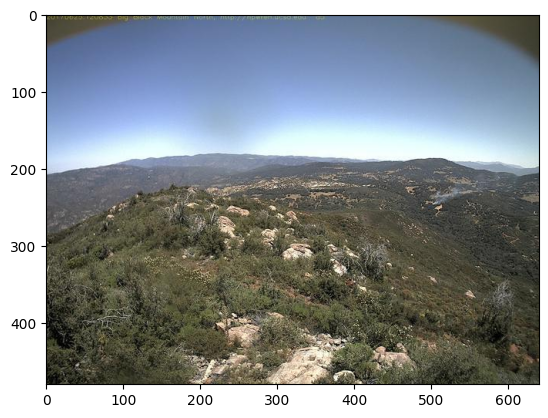

In [ ]:
plt.imshow(sample)

In [ ]:
sample

array([[[0.30588236, 0.29411766, 0.11764706],
        [0.4509804 , 0.4392157 , 0.2627451 ],
        [0.43529412, 0.42352942, 0.24705882],
        ...,
        [0.23137255, 0.22352941, 0.16470589],
        [0.23137255, 0.22352941, 0.16470589],
        [0.23137255, 0.22352941, 0.16470589]],

       [[0.29411766, 0.28235295, 0.11372549],
        [0.42745098, 0.41568628, 0.23921569],
        [0.24705882, 0.23529412, 0.06666667],
        ...,
        [0.23529412, 0.22745098, 0.16862746],
        [0.23137255, 0.22352941, 0.16470589],
        [0.23137255, 0.22352941, 0.16470589]],

       [[0.30980393, 0.29803923, 0.13725491],
        [0.3372549 , 0.3254902 , 0.15686275],
        [0.25882354, 0.24705882, 0.08627451],
        ...,
        [0.23529412, 0.22745098, 0.16862746],
        [0.23529412, 0.22745098, 0.16862746],
        [0.23137255, 0.22352941, 0.16470589]],

       ...,

       [[0.06666667, 0.07058824, 0.03921569],
        [0.03529412, 0.03921569, 0.00784314],
        [0.        , 0

## **9.** Sources

[**1**] PyTorch - Detection functions - https://github.com/pytorch/vision/tree/main/references/detection<br>
[**2**] PyTorch - Tutorials - https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html<br>
[**3**] Dataset (format: CSV - Tensorflow Object Detection) - https://public.roboflow.com/object-detection/wildfire-smoke<br>
[**4**] Kaggle - Starting code - https://www.kaggle.com/code/tarunbisht11/torchvision-object-detection<br>